In [7]:
import duckdb as dk
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
con = dk.connect('///data/vermont.duckdb')

In [37]:
con.close()

In [34]:
query = """
SELECT * FROM locality_lookup
"""
df = con.execute(query).fetchdf()
df.head(10)

,locality,locality_id,locality_type,latitude,longitude,total_checklists
0,Shelburne Bay,165354,H,44.402908,-73.232368,5778
1,Delta Park IBA,165376,H,44.533363,-73.277771,5412
2,Charlotte Town Beach,164833,H,44.334270,-73.281357,3790
3,"Moose Bog, Wenlock WMA",207476,H,44.764008,-71.739410,3667
4,Colchester Pond - Colchester (186 acres),751908,H,44.554634,-73.119843,3566
5,Herrick's Cove IBA,165635,H,43.178577,-72.446640,3276
6,Wilder Dam--boat ramp,687022,H,43.674469,-72.303001,3179
7,Berlin Pond IBA - Berlin (293 acres),150998,H,44.189919,-72.587509,3041
8,North Branch Nature Center,166319,H,44.285198,-72.574600,2775
9,Dead Creek WMA IBA--Brilyea Access,201059,H,44.074551,-73.350998,2759


In [3]:
query = """
SELECT *
FROM locality_lookup
WHERE locality LIKE 'Colchester Pond%'
"""
df = con.execute(query).fetchdf()
df

,locality,locality_id,locality_type,latitude,longitude,total_checklists
0,Colchester Pond - Colchester (186 acres),751908,H,44.554634,-73.119843,3566


<BarContainer object of 53 artists>

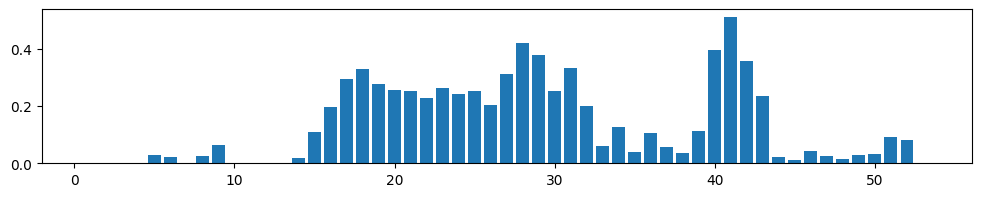

In [4]:
hotspot_id = 751908 # Colchester Pond
species_name = 'Hermit Thrush'
ONE_YEAR = pd.DataFrame({'day_of_year': range(1, 367)})

query = """
SELECT day_of_year, frequency
FROM detection_frequencies
WHERE locality_id = ? AND common_name = ?
ORDER BY day_of_year
"""

df = con.execute(query, [hotspot_id, species_name]).fetchdf()

df_full = ONE_YEAR.merge(df, on='day_of_year', how='left').fillna(0)
df_full['week'] = ((df_full['day_of_year'] - 1 ) // 7) + 1
weekly_avg = df_full.groupby('week')['frequency'].mean().reset_index()

plt.figure(figsize=(12,2))
plt.bar(weekly_avg['week'], weekly_avg['frequency'])


In [3]:
life_list = con.execute("""SELECT * FROM life_list""").df()

In [40]:
life_list.head()

,common_name,scientific_name,taxonomic_order,date,location
0,Turkey Vulture,Cathartes aura,7815,2013-07-31,"Gypsum, Colorado (General Location)"
1,Red-tailed Hawk,Buteo jamaicensis,8506,2013-08-04,Buckskin Pass
2,Clark's Nutcracker,Nucifraga columbiana,21484,2013-08-06,Rocky Mountain NP--Forest Canyon Overlook
3,White Ibis,Eudocimus albus,7462,2014-03-01,"97000 Overseas Highway, Key Largo, Florida, US..."
4,Cedar Waxwing,Bombycilla cedrorum,29888,2015-08-07,Acadia NP--Eagle Lake


In [19]:
fig = go.Figure(go.Scatter(
    x=life_list.date,
    y=life_list.index+1,
    mode='markers',
    marker=dict(
        opacity=0.25
    ),
    hovertemplate=(
        "#%{y}<br>"
        "%{customdata[0]}<br>"
        "%{x|%m-%d-%Y}<br>"
        "%{customdata[1]}"
    ),
    customdata=life_list[['common_name', 'location']].values
))

fig.update_layout(
    title="World Life List Count over Time",
    xaxis_title="Date",
    yaxis_title="Life List Count"
)

fig.update_yaxes(autorangeoptions_minallowed = 0)
fig.show()